# The Basics of Unsupervised Learning: Segmenting an Image

Unsupervised learning is a type of machine learning that looks for previously undetected patterns in a dataset without pre-existing labels and with minimal human supervision. Unlike supervised learning, where the model is trained on labeled data, unsupervised learning works on its own to identify structures and patterns within the data. This makes it particularly useful in situations where labeled data is scarce or unavailable.

One common example of unsupervised learning is clustering, which involves grouping data points into clusters based on their similarities. A widely used algorithm for clustering is k-means, which partitions the data into $\mathbf{k}$ clusters, each represented by a centroid. Applications of clustering include customer segmentation, image segmentation, and biological data analysis.

Another example is anomaly detection, which identifies rare items, events, or observations that raise suspicions by differing significantly from the majority of the data. Anomaly detection is used in various fields such as fraud detection in finance, network security for identifying intrusions, and fault detection in industrial systems.

Dimensionality reduction is also a key technique in unsupervised learning. It reduces the number of random variables under consideration by obtaining a set of principal variables. Techniques like [Principal Component Analysis (PCA) and t-Distributed Stochastic Neighbor Embedding (t-SNE)](pca-vs-tsne) simplify models, reduce computation time, and visualize high-dimensional data. Dimensionality reduction is widely used in data preprocessing, image compression, and noise reduction.

Other applications of unsupervised learning include association rule learning, which discovers interesting relations between variables in large databases. This method is commonly used in market basket analysis to find sets of products that frequently co-occur in transactions. Feature learning is another application where representations or features from raw data that are useful for machine learning tasks are automatically discovered. Techniques like autoencoders and generative adversarial networks (GANs) are used for tasks such as image generation, speech synthesis, and data denoising.

Hierarchical clustering is another form of unsupervised learning that builds a tree of clusters, unlike k-means, which requires a predefined number of clusters. This method is particularly useful for discovering hierarchical relationships in data, such as taxonomies in biology.

Unsupervised learning is crucial in exploratory data analysis, where insights and patterns need to be uncovered without prior knowledge. It helps in understanding the underlying structure of the data, leading to more informed decisions and better data-driven strategies.

In this experiment, we will explore the basics of unsupervised learning by segmenting an image using k-means clustering. We will identify distinct regions in the image, and assign each pixel to a cluster based on its color similarity. This technique is commonly used in image processing for tasks like object detection, image compression, and image segmentation.

## Generating a synthetic landscape

Let's start by generating a synthetic landscape image that we will use for segmentation. To do so, we will create a simple 512x512 "virtual" landscape of different "heights" between 0 and 1.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from noise import pnoise2
from PIL import Image
from skimage.measure import find_contours

def generate_procedural_landscape(size=256, scale=100.0, octaves=6, persistence=0.5, lacunarity=2.0, seed=0):
    """
    Generate a procedural landscape with hills and valleys using Perlin noise.
    
    :param size: The size of the landscape (size x size).
    :param scale: The scale of the noise.
    :param octaves: Number of layers of noise.
    :param persistence: Amplitude of each octave.
    :param lacunarity: Frequency of each octave.
    :param seed: The seed for generating different landscapes.
    :return: A 2D numpy array representing the landscape heights.
    """
    landscape = np.zeros((size, size))
    
    for i in range(size):
        for j in range(size):
            x = (i + seed) / scale
            y = (j + seed) / scale
            landscape[i][j] = pnoise2(x, y, octaves=octaves, persistence=persistence, lacunarity=lacunarity)
    
    # Normalize the values to be between 0 and 1
    min_val = np.min(landscape)
    max_val = np.max(landscape)
    landscape = (landscape - min_val) / (max_val - min_val)
    
    return landscape

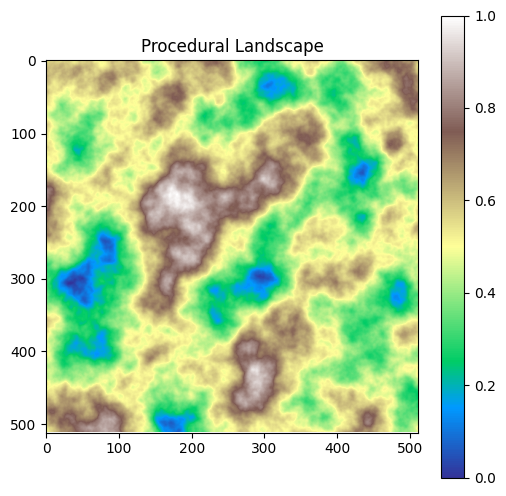

In [18]:
landscape = generate_procedural_landscape(size=512, scale=128)

plt.figure(figsize=(6, 6))
plt.imshow(landscape, cmap='terrain')
plt.title('Procedural Landscape')
plt.colorbar()
plt.show()

We have a simple image, where the pixel intensity represents the height of the landscape. To make it visually intuitive to understand what we are doing, let us identify and visualise isolines of different heights. Isolines are lines that connect points of equal value, such as points of equal height in a landscape.

In [19]:
def landscape_isocontour(landscape, thresholds=[0.3, 0.5, 0.7]):
    """
    Generate iso-contour lines for the landscape.
    
    :param landscape: A 2D numpy array representing the landscape heights.
    :param thresholds: List of threshold values for the isocontours.
    :return: A list of contour arrays.
    """
    contours = []
    for threshold in thresholds:
        contour = find_contours(landscape, level=threshold)
        contours.append(contour)
    return contours

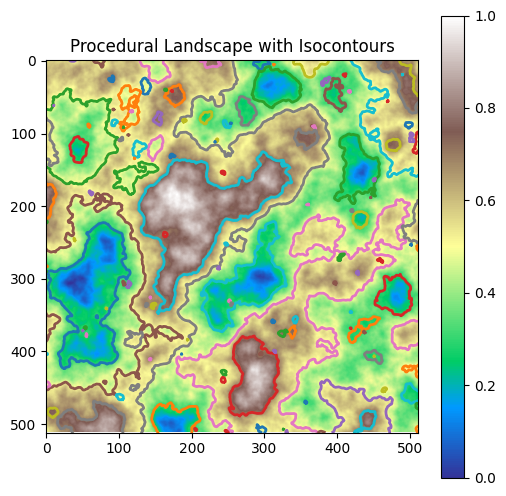

In [20]:
# Generate isocontours for the landscape
contours = landscape_isocontour(landscape, thresholds=[0.3, 0.5, 0.7])

# Plot the landscape with isocontours
plt.figure(figsize=(6, 6))
plt.imshow(landscape, cmap='terrain')
plt.title('Procedural Landscape with Isocontours')
plt.colorbar()
for contour in contours:
    for line in contour:
        plt.plot(line[:, 1], line[:, 0], linewidth=2)
plt.show()

That looks interesting. What we ultimately are trying to synthethise is something which looks like a satellite view of a natural landscape. To do this, let us take this height representation, and convert it into a color representation where low lying areas are blue (water), high lying areas are white (snow), and everything in between is green (grass) or brown (mountains). To do so, we will apply a color map to the height representation, and interpolate between colors to create gradients representing intermediate areas.

In [21]:
def lerp(color1, color2, t):
    """
    Linearly interpolate between two colors.
    
    :param color1: The first color (as an array of [R, G, B]).
    :param color2: The second color (as an array of [R, G, B]).
    :param t: The interpolation parameter (0 <= t <= 1).
    :return: The interpolated color.
    """
    return (1 - t) * np.array(color1) + t * np.array(color2)

def apply_colormap(landscape,
                   water_color=[20, 20, 220],
                   grass_color=[20, 220, 20],
                   mountain_color=[139, 69, 19],
                   snow_color=[220, 220, 220],
                   transition_width=0.05,
                   water_threshold=0.4,
                   grass_threshold=0.6,
                   mountain_threshold=0.8):
    """
    Apply a colormap to the landscape to simulate various elements (e.g., water, grass, mountains, snow) with soft edges.
    
    :param landscape: A 2D numpy array representing the landscape heights.
    :return: A 3D numpy array with RGB values.
    """
    
    # Create an RGB image
    rgb_image = np.zeros((landscape.shape[0], landscape.shape[1], 3), dtype=np.uint8)
    
    # Apply colors based on thresholds with gradients
    for i in range(landscape.shape[0]):
        for j in range(landscape.shape[1]):
            height = landscape[i, j]
            
            if height < water_threshold - transition_width:
                rgb_image[i, j] = water_color
            elif height < water_threshold + transition_width:
                t = (height - (water_threshold - transition_width)) / (2 * transition_width)
                rgb_image[i, j] = lerp(water_color, grass_color, t)
            elif height < grass_threshold - transition_width:
                rgb_image[i, j] = grass_color
            elif height < grass_threshold + transition_width:
                t = (height - (grass_threshold - transition_width)) / (2 * transition_width)
                rgb_image[i, j] = lerp(grass_color, mountain_color, t)
            elif height < mountain_threshold - transition_width:
                rgb_image[i, j] = mountain_color
            elif height < mountain_threshold + transition_width:
                t = (height - (mountain_threshold - transition_width)) / (2 * transition_width)
                rgb_image[i, j] = lerp(mountain_color, snow_color, t)
            else:
                rgb_image[i, j] = snow_color
    
    return rgb_image

def landscape_as_image(landscape, transition_width=0.1):
    """
    Save the procedural landscape as a colorful image file.
    
    :param landscape: A 2D numpy array representing the landscape heights.
    :param filename: The filename to save the image as.
    """
    # Apply the colormap
    rgb_image = apply_colormap(landscape, transition_width=transition_width)
    
    # Create an image object
    image = Image.fromarray(rgb_image, mode='RGB')
    
    return image

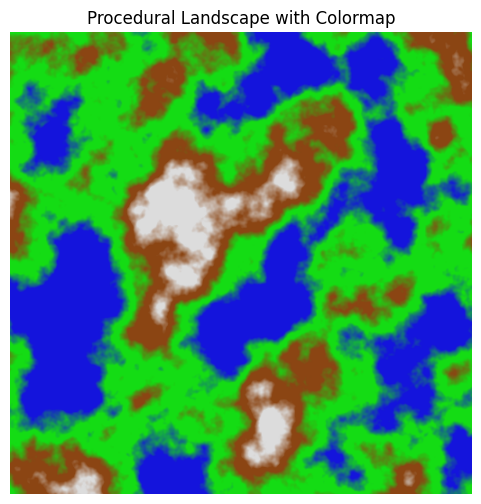

In [22]:
# Convert the landscape to an image which represents different elements, such as water, grass, mountains, and snow
landscape_image = landscape_as_image(landscape, transition_width=0.06)

plt.figure(figsize=(6, 6))
plt.imshow(landscape_image)
plt.title('Procedural Landscape with Colormap')
plt.axis('off')
plt.show()

Now we got somewhere! We have a synthetic landscape image that we can use for segmentation. Let's move on to the next step.

## Segmentation using k-means clustering

Now that we have our synthetic landscape image, we will segment it using k-means clustering. The goal is to group pixels with similar colors together, forming distinct regions in the image. k-means clustering is an iterative algorithm that partitions the data into $\mathbf{k}$ clusters based on the similarity of their features. In our case, the features are the RGB values of each pixel.

In [23]:
from sklearn.cluster import KMeans

def classify_image(image, n_clusters=10):
    """
    Classify the image into regions using K-means clustering.
    
    :param image_np: A numpy array representing the image.
    :param n_clusters: The number of clusters to classify into.
    :return: A 2D numpy array with cluster labels and the cluster centers as RGB values.
    """
    # Convert the image to a numpy array
    image_np = np.array(image)

    # Reshape the image to a list of pixels
    pixels = image_np.reshape(-1, 3)
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(pixels)
    
    # Get the cluster labels and centers
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    # Reshape the labels back to the original image shape
    classified_image = labels.reshape(image_np.shape[:2])
    
    return classified_image, centers

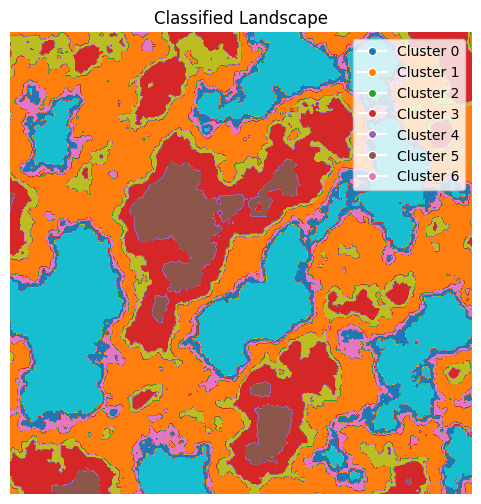

In [24]:
# Classify the image using K-means clustering

classified_image, centers = classify_image(landscape_image, n_clusters=7)

# Show the classified image, with a symbolic colormap, include a legend with the cluster centers
plt.figure(figsize=(6, 6))
plt.imshow(classified_image, cmap='tab10')
plt.title('Classified Landscape')
plt.axis('off')

# Get the colormap colors for the legend
colormap = plt.get_cmap('tab10')
colors = [colormap(i) for i in range(len(centers))]

plt.legend(handles=[plt.Line2D([0], [0], 
                               marker='o',
                               color='w',
                               label=f'Cluster {i}', markerfacecolor=colors[i]) for i in range(len(centers))], loc='upper right',
                               bbox_to_anchor=(1, 1))
plt.show()

What you see is a segmented image where each color represents a different cluster. The algorithm has grouped pixels with similar colors together, creating distinct regions in the image. The image has been painted with a color palette that represents the different clusters identified by the algorithm, and which do not necessarily correspond to the original colors of the landscape.

Let us now turn the classification into a segmented image, where each pixel is colored back according to the type of landscape the cluster represents. This will give us a visual representation of the segmentation results which is close to the original image (think of it as a "paint by numbers" exercise which will eliminate the gradient colors). We do this by replacing the RGB values of each pixel with the centroid of the cluster it belongs to.

In [25]:
from scipy.spatial.distance import cdist


# Define color dictionary for the colormap
color_dict = {
    'water': [20, 20, 220],     # Blue for water
    'grass': [20, 255, 20],     # Green for grass
    'mountains': [139, 69, 19], # Brown for mountains
    'snow': [220, 220, 220]     # White for snow
}
# Define target colors for each landscape element
target_colors = np.array([
    color_dict['water'],
    color_dict['grass'],
    color_dict['mountains'],
    color_dict['snow']])

def segment_with_colormap(classified_image, centers):
    """
    Apply a colormap to the classified image.
    
    :param classified_image: A 2D numpy array with cluster labels.
    :param centers: The cluster centers.
    :return: A 3D numpy array with RGB values.
    """
    
    # Match the cluster centers to the target colors
    distances = cdist(centers, target_colors)
    closest_colors = np.argmin(distances, axis=1)
    
    # Create an RGB image
    rgb_image = np.zeros((classified_image.shape[0], classified_image.shape[1], 3), dtype=np.uint8)
    
    for cluster_label in range(len(centers)):
        rgb_image[classified_image == cluster_label] = target_colors[closest_colors[cluster_label]]
    
    return rgb_image, closest_colors

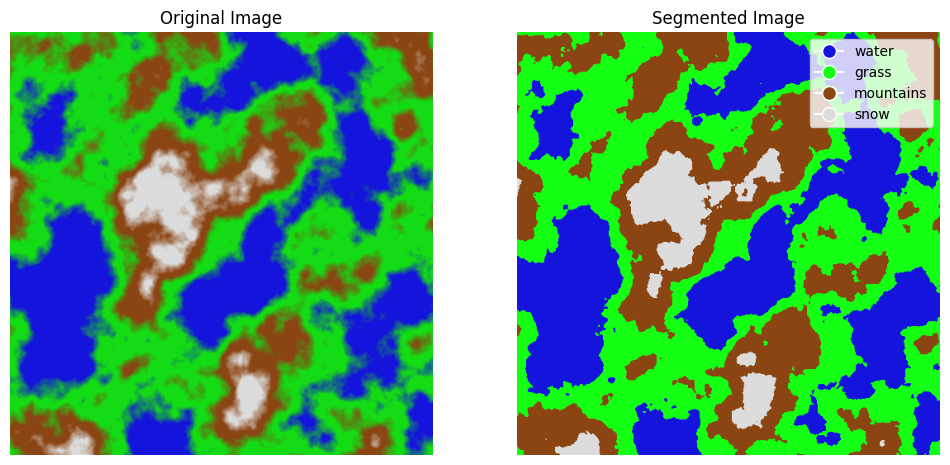

In [26]:
# Apply the cluster colormap to the classified image
segmented_image, closest_colors = segment_with_colormap(classified_image, centers)

# Show the original image and the cluster-colored image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(landscape_image)
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(segmented_image)
ax[1].set_title('Segmented Image')
ax[1].axis('off')
# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=target_colors[i]/255, markersize=10) for i in range(len(target_colors))]
labels = color_dict.keys()
ax[1].legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1))
plt.show()

That's starting to make sense. We now have a segmented image that represents the different regions in the landscape. Each pixel has been assigned to a cluster based on its color similarity and colored according to the centroid of the cluster. This process has created distinct regions in the image, making it easier to identify different parts of the landscape. This technique is commonly used in image processing for tasks like object detection, where the goal is to locate and identify objects within an image. By segmenting the image into different regions, it's possible to isolate areas of interest and perform further analysis on them.

In addition to object detection, image segmentation is also used in medical imaging to identify and delineate structures within the body, such as organs, tissues, and tumors. This helps doctors and radiologists in diagnosing diseases and planning treatments. In satellite and aerial imagery, segmentation helps in classifying land cover types, such as urban areas, forests, and bodies of water, aiding in environmental monitoring and urban planning. Another application of image segmentation is in autonomous driving, where it is essential to recognize and understand various elements of the road environment, including vehicles, pedestrians, road signs, and lane markings. By segmenting the image, autonomous vehicles can make better decisions and navigate more safely.

It is also crucial in the field of computer vision for applications such as facial recognition, where different parts of the face are segmented to extract features like eyes, nose, and mouth. This improves the accuracy of recognition systems and enables more advanced functionalities like emotion detection. This kind of analysis serves as a foundational technique in many areas of image processing and computer vision, enabling more precise and efficient analysis of visual data. By breaking down an image into meaningful segments, we can gain deeper insights and develop more advanced algorithms for a wide range of applications.

Back to clustering, we should also mention that the number of clusters $\mathbf{k}$ is a hyperparameter that needs to be tuned based on the data and the desired level of granularity. Choosing the right number of clusters is essential for obtaining meaningful results and avoiding overfitting or underfitting. Techniques like the elbow method, silhouette score, and cross-validation can help in determining the optimal number of clusters for a given dataset.

```{index} Elbow method
```

```{tip}
The elbow method is a technique used to determine the optimal number of clusters in a dataset for k-means clustering. It involves running k-means clustering on the dataset for a range of values for $\mathbf{k}$ (the number of clusters) and then plotting the within-cluster sum of squares ($\mathbf{WCSS}$) against the number of clusters. The $\mathbf{WCSS}$ measures the sum of the squared distances between each data point and the centroid of the cluster it belongs to, serving as a measure of the compactness of the clusters; lower $\mathbf{WCSS}$ values indicate more compact clusters.

The critical step is identifying the point where the rate of decrease in $\mathbf{WCSS}$ slows down significantly, known as the "elbow." This point indicates that increasing the number of clusters beyond this point does not significantly improve the compactness of the clusters, suggesting that the optimal number of clusters has been reached. The elbow point represents a balance between having a low $\mathbf{WCSS}$ and avoiding too many clusters, which could lead to overfitting.

The elbow method is a heuristic that can be useful in many situations, but it is not always definitive. In some cases, the elbow may not be clearly identifiable, or there may be multiple elbows, making it challenging to determine the optimal number of clusters. In such cases, other methods, such as the silhouette score or the gap statistic, can be used alongside the elbow method to validate the choice of $\mathbf{k}$.
```

### Determining the optimal number of clusters

Let's visually compare the results of k-means clustering for different values of $\mathbf{k}$ to determine the optimal number of clusters for our synthetic landscape image. We will run k-means clustering for $\mathbf{k=2, 3, 4, 5, 6, 7, 8, 9, 10}$ and visualize the segmented images for each value of $\mathbf{k}$, and visually compare.

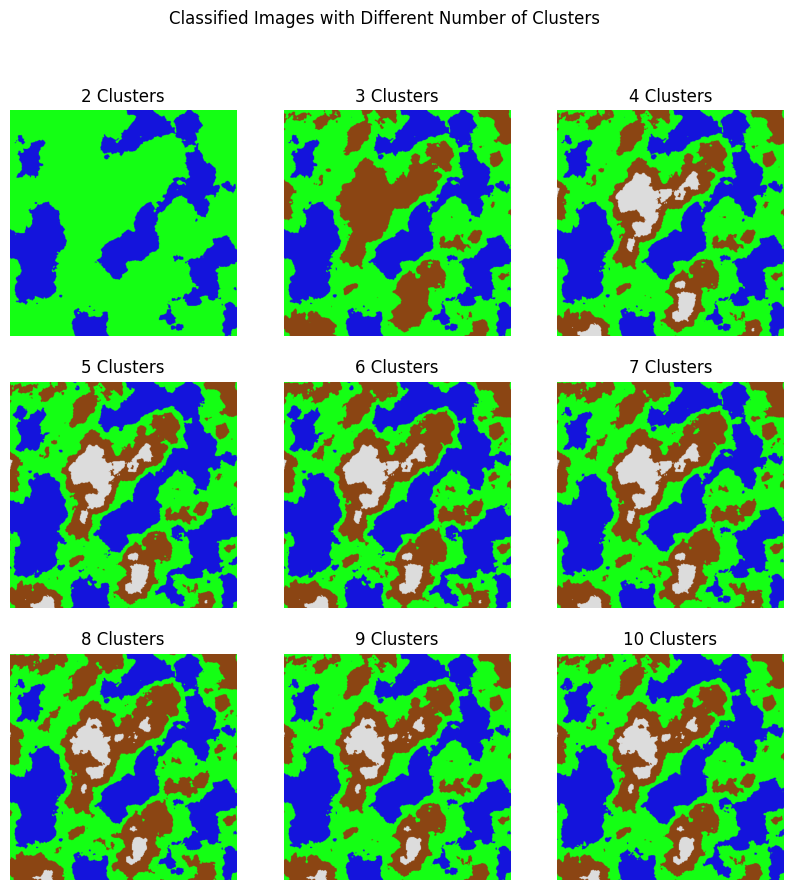

In [27]:
# Create a grid of classified images with different number of clusters
n_clusters = 10
fig = plt.figure(figsize=(10, 10))
plt.suptitle('Classified Images with Different Number of Clusters', fontsize=12)
for i in range(2, n_clusters + 1):
    _classified_image, _centers = classify_image(landscape_image, n_clusters=i)
    _color_mapped_image, _ = segment_with_colormap(_classified_image, _centers)
    
    plt.subplot(3, 3, i - 1)
    plt.imshow(_color_mapped_image)
    plt.axis('off')
    plt.title(f'{i} Clusters')

plt.show()

We can see that as the number of clusters increases, the image becomes more finely segmented, capturing more detailed regions in the landscape. However, beyond a certain point, adding more clusters does not significantly improve the segmentation quality and may lead to overfitting. The optimal number of clusters depends on the desired level of granularity and the complexity of the image. Let us try the elbow method to determine the optimal number of clusters for our synthetic landscape image.

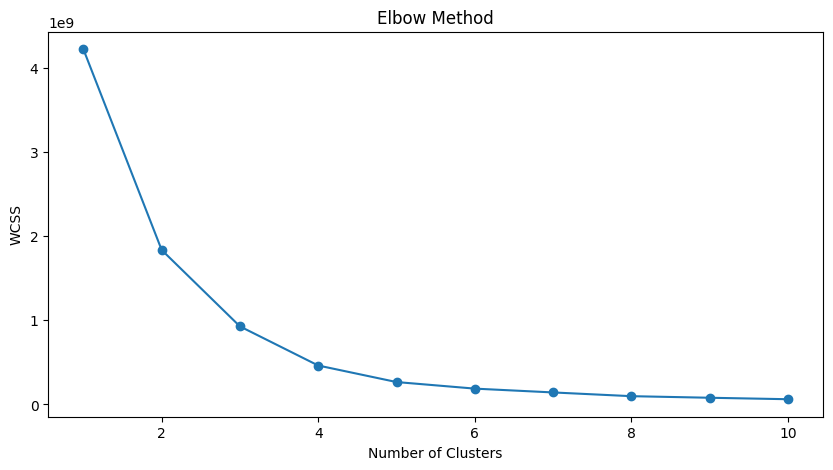

In [28]:
# Calculate WCSS for different values of k
wcss = []
n_clusters_range = range(1, 11)
for i in n_clusters_range:
    _, centers = classify_image(landscape_image, n_clusters=i)
    pixels = np.array(landscape_image).reshape(-1, 3)
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(pixels)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values
plt.figure(figsize=(10, 5))
plt.plot(n_clusters_range, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

It looks like the optimal number of clusters for our synthetic landscape image is around $\mathbf{k=4}$, as the rate of decrease in $\mathbf{WCSS}$ slows down significantly after this point. We can use the "knee" method to mathematically determine the optimal number of clusters, but in practice, it is often a subjective decision based on the data and the desired level of granularity.

In [32]:
from kneed import KneeLocator

# Find the "elbow" point
kneedle = KneeLocator(n_clusters_range, wcss, curve='convex', direction='decreasing')
optimal_n_clusters = kneedle.elbow

print(f'Optimal number of clusters: {optimal_n_clusters}')

Optimal number of clusters: 4


We were right in our initial assumption! The optimal number of clusters for our synthetic landscape image is indeed $\mathbf{k=4}$ according to the knee method. Let us now look for the boundaries between the clusters to better understand the segmentation results. We will overlay the cluster boundaries on the segmented image to visualize the regions where the clusters meet.

In [ ]:
from skimage.segmentation import find_boundaries

def find_image_boundaries(classified_image):
    """
    Find the boundaries of classified regions in the image and label them.
    
    :param classified_image: A 2D numpy array with cluster labels.
    :param closest_colors: The mapped color labels for each cluster.
    :return: A 2D numpy array with boundaries.
    """
    boundaries = find_boundaries(classified_image, mode='thick')
    return boundaries

(-0.5, 511.5, 511.5, -0.5)

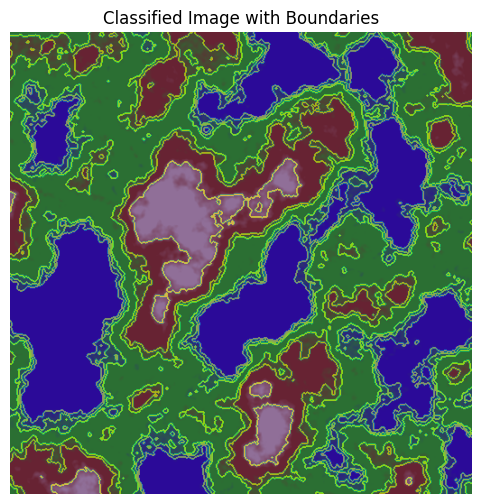

In [33]:
# Find the boundaries in the classified image
boundaries_image = find_image_boundaries(classified_image)

# Plot the classified image overlayed with boundaries
plt.figure(figsize=(6, 6))
plt.imshow(landscape_image)
plt.imshow(boundaries_image, alpha=0.5)
plt.title('Classified Image with Boundaries')
plt.axis('off')

## Wraping it up

We have successfully segmented the synthetic landscape image using k-means clustering and visualized the results. The segmentation has created distinct regions in the image, making it easier to identify different parts of the landscape. By assigning each pixel to a cluster based on its color similarity, we have grouped pixels with similar colors together, forming meaningful segments in the image.
 
 To wrap things up, let us overlay everything with different landscape markers to map the different regions of the synthetic landscape image.

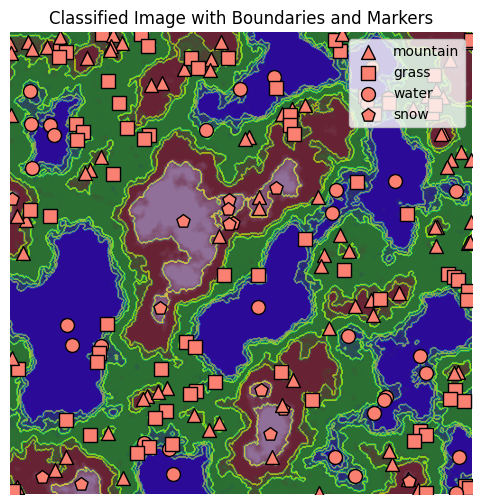

In [34]:
from skimage.measure import regionprops, label

# Define labels for each landscape element
labels_dict = {
    0: 'Water',
    1: 'Grass',
    2: 'Mountain',
    3: 'Snow'
}

# Display boundaries image
plt.figure(figsize=(6, 6))
plt.imshow(landscape_image)
plt.imshow(boundaries_image, alpha=0.5)
plt.title('Classified Image with Boundaries and Markers')
plt.axis('off')

# Use regionprops to find centroids of each region and add one label per class
labeled_array, num_features = label(classified_image, return_num=True)
props = regionprops(labeled_array)

# Define symbols for each landscape element
symbols_dict = {
    0: ('o', 'water'),
    1: ('s', 'grass'),
    2: ('^', 'mountain'),
    3: ('p', 'snow')
}

# To avoid duplicate labels in the legend
handles = {}

for prop in props:
    y, x = prop.centroid
    label_index = classified_image[int(y), int(x)]
    symbol, label_text = symbols_dict.get(closest_colors[label_index], ('x', 'Unknown'))
    scatter = plt.scatter(x, y, marker=symbol, color='salmon', s=100, edgecolor='black', label=label_text)
    
    # Add to handles only if label_text not already added
    if label_text not in handles:
        handles[label_text] = scatter

# Create a legend
plt.legend(handles=handles.values(), labels=handles.keys(), loc='upper right')

plt.show()

## Final remarks

Unsupervised learning techniques like k-means clustering are powerful tools for segmenting images and identifying patterns in data. By grouping similar pixels together, we can create meaningful segments in the image, enabling further analysis and interpretation. Image segmentation is a fundamental task in computer vision and image processing, with applications in object detection, medical imaging, satellite imagery, and autonomous driving, among others. Understanding the basics of unsupervised learning and image segmentation is essential for developing advanced algorithms and applications in these fields.

This simple experiment demonstrated some basic concepts of unsupervised learning using the k-means algorithm. However, there are several other techniques and methods that can be explored for more sophisticated image segmentation and data analysis. For instance, hierarchical clustering doesn't require specifying the number of clusters in advance and builds a hierarchy of clusters that can be visualized using a dendrogram. This technique is useful for discovering nested clusters and understanding data at multiple levels of granularity.

Another method is DBSCAN (Density-Based Spatial Clustering of Applications with Noise), which is based on the density of data points. It is particularly effective for datasets with noise and varying cluster shapes, identifying clusters of arbitrary shapes and handling outliers effectively. Gaussian Mixture Models (GMM) provide a probabilistic approach, assuming data points are generated from a mixture of several Gaussian distributions. This allows for soft clustering, where each data point is assigned a probability of belonging to each cluster, enabling more nuanced cluster memberships.

Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms data into a lower-dimensional space while preserving as much variance as possible. It is often used before clustering to reduce the dimensionality of data, making it easier to visualize and analyze. Autoencoders, neural networks used for unsupervised learning, learn efficient representations of data by training the network to reconstruct its input. They are useful for tasks like dimensionality reduction, anomaly detection, and feature learning.

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a nonlinear dimensionality reduction technique that is particularly good for visualizing high-dimensional data in 2D or 3D space, commonly used for exploring and visualizing complex data patterns. Self-Organizing Maps (SOM) are a type of artificial neural network used for unsupervised learning, producing a low-dimensional representation of the input space while preserving topological properties. SOMs are valuable for visualizing and clustering high-dimensional data.

Generative Adversarial Networks (GANs) consist of two neural networks, a generator and a discriminator, that compete against each other. While GANs are mainly known for generating realistic data samples, they can also be used for unsupervised learning tasks such as anomaly detection and semi-supervised learning. Exploring these techniques will provide a deeper understanding of unsupervised learning and its applications in various fields. By leveraging the strengths of different methods, you can develop more robust and effective algorithms for complex data analysis and image segmentation tasks.